# Tabnet

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch    
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import random
#ordinal encoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
#import lda and pca
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import itertools
import copy

seed = 42

#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [12]:

class TabNet(torch.nn.Module):
    '''
    Wrapper class for TabNetClassifier
    '''
    def __init__(self, n_d,
                 n_a,
                 n_steps,
                 gamma,
                 optimizer_fn,
                 n_independent,
                 n_shared,
                 epsilon,
                 seed,
                 lambda_sparse,
                 clip_value,
                 momentum,
                 optimizer_params,
                 scheduler_params,
                 mask_type,
                 scheduler_fn,
                 device_name,
                 output_dim,
                 batch_size,
                 num_epochs,
                 unsupervised_model,
                 verbose=0):
        super(TabNet, self).__init__()

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.unsupervised_model = unsupervised_model
        self.network = TabNetClassifier(n_d=n_d,
                                        n_a=n_a,
                                        n_steps=n_steps,
                                        gamma=gamma,
                                        optimizer_fn=optimizer_fn,
                                        n_independent=n_independent,
                                        n_shared=n_shared,
                                        epsilon=epsilon,
                                        seed=seed,
                                        lambda_sparse=lambda_sparse,
                                        clip_value=clip_value,
                                        momentum=momentum,
                                        optimizer_params=optimizer_params,
                                        scheduler_params=scheduler_params,
                                        mask_type=mask_type,
                                        scheduler_fn=scheduler_fn,
                                        device_name=device_name,
                                        output_dim=output_dim,
                                        verbose=verbose)
    
    def fit_model(self, X_train, y_train, X_val, y_val, criterion):
        self.network.fit(X_train=X_train, 
                         y_train=y_train, 
                         eval_set=[(X_train,y_train),(X_val, y_val)], 
                         eval_metric=['balanced_accuracy'], 
                         patience=10, 
                         batch_size=self.batch_size, 
                         virtual_batch_size=128, 
                         num_workers=0, 
                         drop_last=True, 
                         max_epochs=self.num_epochs, 
                         loss_fn=criterion, 
                         from_unsupervised=self.unsupervised_model)

    def predict(self, X):
        return self.network.predict(X)
    
    def explain(self, X):
        return self.network.explain(X)
    
    def feature_importances(self):
        return self.network.feature_importances_

def get_unsupervised_model(n_d_a,n_step,n_independent,n_shared,gamma,lr):
    tabnet_params = dict(n_d=n_d_a, 
                        n_a=n_d_a,
                        n_steps=n_step,
                        gamma=gamma,
                        n_independent=n_independent,
                        n_shared=n_shared,
                        lambda_sparse=1e-3,
                        optimizer_fn=torch.optim.AdamW, 
                        optimizer_params=dict(lr=lr),
                        mask_type="sparsemax",
                        verbose=0
                        )
    unsupervised_model = TabNetPretrainer(**tabnet_params)
    return unsupervised_model

# hp conf

In [13]:
nums_epochs = [10]
batch_sizes = [512]
patience = [10,20]
n_d_a = [16]
n_shared = [8,16]
n_indipendents = [1] 
n_steps = [8,9]
gamma = [1.0]
epsilon = [1e-15]
learning_rate = [0.01]
pretraining_ratio = [0.5]
momentum = [0.99]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))
n_comb = len(hyperparameters)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 16


In [14]:


#read the dataset
df = pd.read_csv('train_dataset.csv')

#DATA CLEANING

#filter numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

#filter categorical columns
cat_columns = df.select_dtypes(include=[object]).columns.tolist()

# replace '-' values in n columns with the mean of the column(both int and float columns)
for column in num_columns:
    df[column] = df[column].replace('-', df[column].mean())

# replace '-' values in categorical columns with the mode of the column
for column in cat_columns:
    df[column] = df[column].replace('-', df[column].mode().iloc[0])

# Convert all categorical columns to strings
df[cat_columns] = df[cat_columns].astype(str)
label_values_original = df["type"].unique()
encoder = OrdinalEncoder()
df[cat_columns] = encoder.fit_transform(df[cat_columns])



X = df.drop(columns=["type","label"]).to_numpy()
y = df["type"].to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)


# Encoding target
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

#print the value encoded for each class
print(le.classes_)

#PREPROCESSING

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Apply LDA
# lda = LinearDiscriminantAnalysis()
# X_train = lda.fit_transform(X_train, y_train)
# X_test = lda.transform(X_test)

#apply PCA
# pca = PCA(n_components='mle',svd_solver='full')
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)



print(f'X_train shape after pca: {X_train.shape}')

num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Split train data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


#from numpy to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=Y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

C:\Users\rinal\AppData\Local\Temp\ipykernel_17132\711053198.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv')


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
X_train shape after pca: (493601, 44)


In [15]:
#import class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(4.069593536153022), 1: np.float64(0.338110666630134), 2: np.float64(1.132579964205406), 3: np.float64(4.543873699714628), 4: np.float64(98.7202), 5: np.float64(2.983745390799734), 6: np.float64(1.196724530863599), 7: np.float64(63.855239327296246), 8: np.float64(0.2880440935324428), 9: np.float64(0.9752262219939147)}


# Training

In [16]:
current_iter = 0
best_acc = 0
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
    
    print(f'Iteration {current_iter+1}/{n_comb}')
    print(f'Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}')

    unsupervised_model = get_unsupervised_model(n_d, n_steps_, n_i, n_s, gamma_, lr)
        
    unsupervised_model.fit(
        X_train=X_train,
        eval_set=[X_val],
        max_epochs=num_epochs,
        patience=patience_,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        pretraining_ratio=pretraining_ratio_,
    )

    model = TabNet(n_d=n_d,
                   n_a=n_d,
                   n_steps=n_steps_,
                   gamma=gamma_,
                   optimizer_fn=torch.optim.AdamW,
                   n_independent=n_i,
                   n_shared=n_s,
                   epsilon=epsilon_,
                   seed=seed,
                   lambda_sparse=1e-4,
                   clip_value=1,
                   momentum=moment,
                   optimizer_params=dict(lr=lr),
                   scheduler_params=dict(step_size=10, gamma=0.9),
                   mask_type='sparsemax',
                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                   device_name=device,
                   output_dim=len(np.unique(y_train)),
                   batch_size=batch_size,
                   num_epochs=num_epochs,
                   unsupervised_model=None,
                   verbose=0)
    model.fit_model(X_train, Y_train, X_val, Y_val, criterion)    
    y_pred = model.predict(X_val)
    acc = accuracy_score(Y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}"
    current_iter += 1

Iteration 1/16
Hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=8, n_steps=8, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 10201.6435546875


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_1_balanced_accuracy = 0.96822


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 2/16
Hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=8, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 14501.203125


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_1_balanced_accuracy = 0.96827


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 3/16
Hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=16, n_steps=8, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 2549.381591796875


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_1_balanced_accuracy = 0.96526


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 4/16
Hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=16, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 24032.125


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 1 and best_val_1_balanced_accuracy = 0.92036


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 5/16
Hyperparameters: num_epochs=10, batch_size=256, patience=20, n_d=16, n_indipendent=1, n_shared=8, n_steps=8, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 10201.6435546875


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_1_balanced_accuracy = 0.96822


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 6/16
Hyperparameters: num_epochs=10, batch_size=256, patience=20, n_d=16, n_indipendent=1, n_shared=8, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 14501.203125


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_1_balanced_accuracy = 0.96827


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 7/16
Hyperparameters: num_epochs=10, batch_size=256, patience=20, n_d=16, n_indipendent=1, n_shared=16, n_steps=8, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 2549.381591796875


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_1_balanced_accuracy = 0.96526


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Iteration 8/16
Hyperparameters: num_epochs=10, batch_size=256, patience=20, n_d=16, n_indipendent=1, n_shared=16, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 24032.125


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 1 and best_val_1_balanced_accuracy = 0.92036


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KeyboardInterrupt: 

# Testing

Best model hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=8, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Accuracy: 0.9882253790487922

Balanced accuracy: 0.9683580649773453

              precision    recall  f1-score   support

      normal       1.00      0.97      0.98      3032
    scanning       1.00      1.00      1.00     36497
         dos       0.97      1.00      0.98     10896
   injection       0.99      1.00      0.99      2716
        ddos       0.57      0.98      0.72       125
    password       0.99      0.77      0.87      4136
         xss       0.99      0.99      0.99     10311
  ransomware       0.28      0.99      0.43       193
    backdoor       1.00      1.00      1.00     42841
        mitm       0.98      0.98      0.98     12654

    accuracy                           0.99    123401
   macro avg       0.88      0.97      0.89    123401
weighted avg       0.99      0.99  

<Figure size 2000x2000 with 0 Axes>

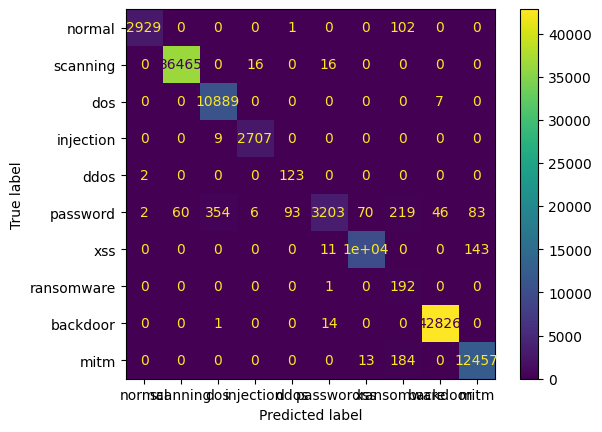

In [18]:
#save best model as best_tabnet
torch.save(best_model, 'models/best_tabnet')

#save best hp
with open('models/best_tabnet_hp.txt', 'w') as f:
    f.write(best_hyperparameters)
    
print(f'Best model hyperparameters: {best_hyperparameters}')
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}\n')

#compute the classficication report
from sklearn.metrics import classification_report,balanced_accuracy_score

#print balanced accuracy
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n')


print(classification_report(y_test, y_pred, target_names=label_values_original))
#save it
with open('models/best_tabnet_classification_report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred, target_names=label_values_original))
#compute the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values_original)
disp.plot()
plt.show()

# Explainability

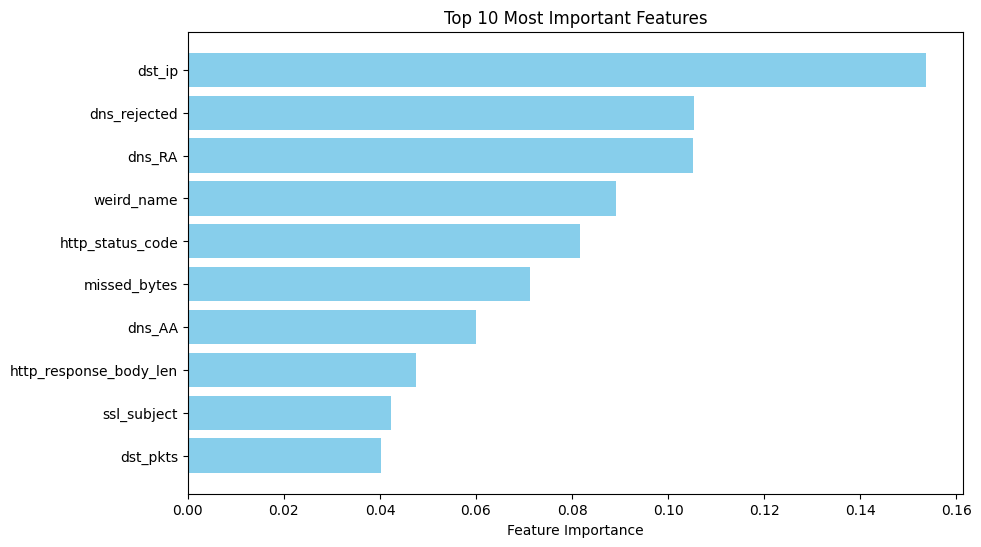

In [36]:
# Assuming `feature_importances` is a numpy array containing the importance values
# and `feature_names` is a list of names corresponding to the features
feature_importances = best_model.network.feature_importances_
feature_names = df.drop(columns=['type','label']).columns

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(feature_importances)[-10:][::-1]
top_features = feature_importances[indices]
top_feature_names = feature_names[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_features, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()